# Deep Surveillance

Surveillance systems, mainly composed of cameras, are today widespread in both indoor and outdoor environments.

- Video surveillance involves the act of observing a scene or scenes and looking for specific behaviors that are improper or that may indicate the emergence or existence of improper behavior.

- Common uses of video surveillance include observing the public at the entry to sports events, public transportation (train platforms, airports, etc.), and around the perimeter of secure facilities, especially those that are directly bounded by community spaces.

In this project, convolutional neural networks using image recognition and their combination with recurrent neural networks temporal information is extracted using which an intelligent surveillance system is made.The LSTM Encoder-Decoder framework is used to learn representation of video sequences and applied for detect abnormal event in complex environment.The abnormal events are identified by computing the reconstruction loss using Euclidean distance between original and reconstructed batch.

Our training dataset contains 16 training and 21 testing video clips. The videos are captured in CUHK campus avenue with 30652 (15328 training, 15324 testing) frames in total.

This dataset accompanies paper "Abnormal Event Detection at 150 FPS in Matlab, Cewu Lu, Jianping Shi, Jiaya Jia, International Conference on Computer Vision, (ICCV), 2013".

The training videos capture normal situations. Testing videos include both normal and abnormal events. Three abnormal activities as follows:

- Strange action	
- Wrong direction	
- Abnormal object

## Import Libraries

In [1]:
import numpy as np
import glob
import os 
import cv2
from keras.preprocessing.image import img_to_array,load_img
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from PIL import Image
import imutils
import matplotlib.pyplot as plt

2024-07-25 11:39:59.896652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 11:39:59.952193: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 11:40:01.035228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Changing current path

In [13]:
# cd C:\Users\Developer\Desktop\training
os.chdir('/home/a2zproviders/Desktop/mlops/DeepSurveillance')

In [15]:
pwd

'/home/a2zproviders/Desktop/mlops/DeepSurveillance'

## Creating training data path and folder

In [16]:
store_image=[]
# train_path='C:\\Users\\Developer\\Desktop\\training'
train_path = "/home/a2zproviders/Desktop/mlops/DeepSurveillance"
train_videos=os.listdir(train_path)
train_images_path=train_path+'/frames'

In [17]:
try:
      
    # creating a folder named data
    if not os.path.exists('frames'):
        os.makedirs('frames')
  
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')

## Helper functions for model

- store_inarry function convert the images into array and store them as gray scale images array in store_image list. 
- into_frames function capture the video and read it frame by frame, it skips every 10 frames and capture a image from it because creating images for frame is computationally very high. 
- mean_squared_loss function is used for calculating the loss.

In [5]:
def store_inarray(image_path):
    image=load_img(image_path)
    image=img_to_array(image)
    image=cv2.resize(image, (227,227), interpolation = cv2.INTER_AREA)
    gray=0.2989*image[:,:,0]+0.5870*image[:,:,1]+0.1140*image[:,:,2]  ##To convert an RGB image to grayscale, you can use the RGB2GRAY command from the Image Processing Toolbox. If you do not have this toolbox, then you can use the standard NTSC conversion formula that is used for calculating the effective luminance of a pixel:intensity = 0.2989*red + 0.5870*green + 0.1140*blue
    store_image.append(gray)

In [7]:
def into_frames(train_path,video):
    cam=cv2.VideoCapture(train_path+'\\'+video)
    i = 0
    j = 0
    # a variable to set how many frames you want to skip
    frame_skip = 10
    while cam.isOpened():
        ret, frame = cam.read()     # read returns a tuple (bool value, image)
        if not ret:
            break
        if i > frame_skip - 1:
            # if video is still left continue creating images
            name = './frames/' + video + '_image_' + str(j) + '.jpg'
            print ('Creating...' + name)
            cv2.imwrite(name, frame)
            i = 0
            continue
        i += 1
        j += 1

    cam.release()
    cv2.destroyAllWindows()

In [8]:
def mean_squared_loss(x1,x2):
    difference=x1-x2
    a,b,c,d,e=difference.shape
    n_samples=a*b*c*d*e
    sq_difference=difference**2
    Sum=sq_difference.sum()
    distance=np.sqrt(Sum)
    mean_distance=distance/n_samples

    return mean_distance

## Creating videos into images frame by frame

In [9]:
for video in train_videos:
    into_frames(train_path,video)

In [18]:
images=os.listdir(train_images_path)
for image in images:
    image_path=train_images_path + '/' + image
    store_inarray(image_path)

In [ ]:
len(images)

14990

## Store the standardized data in a numpy file

We have standardized our data because it makes sure that data is internally consistent; that is, each data type has the same content and format. Standardized values are useful for tracking data that isn't easy to compare otherwise.Then we have finally stored our data in a numpy file.

In [20]:
store_image=np.array(store_image,dtype='uint8')
a,b,c=store_image.shape

store_image.resize(b,c,a)
store_image=(store_image-store_image.mean())/(store_image.std()) # Normalization (x-mean)/standard_deviation (Data Standardization)
store_image=np.clip(store_image,0,1)
#print(store_image)
np.save('training.npy',store_image)

ValueError: not enough values to unpack (expected 3, got 1)

In [21]:
store_image.shape

(0,)

In [22]:
store_image

array([], dtype=uint8)

## Defining model

In [23]:
model=Sequential()

model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='relu'))
model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='relu'))
model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='relu'))
model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='relu'))

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

## Training and saving model

In [24]:
training_data=np.load('training.npy')
frames=training_data.shape[2]
frames=frames-frames%10

training_data=training_data[:,:,:frames]
training_data=training_data.reshape(-1,227,227,10)
training_data=np.expand_dims(training_data,axis=4)
target_data=training_data.copy()

epochs=10
batch_size=10

callback_save = ModelCheckpoint("saved_model.h5", monitor="mean_squared_error", save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history=model.fit(training_data,target_data, batch_size=batch_size, epochs=epochs, callbacks = [callback_save,callback_early_stopping])
model.save("saved_model.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'training.npy'

## Visualization of loss and accuracy on Training data 

In [26]:
train_loss=history.history['loss']
train_acc=history.history['accuracy']


NameError: name 'history' is not defined

In [25]:
plt.figure(figsize=(8,6))
plt.plot(train_loss)
plt.xlabel('Number_of_epochs')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend(['Train'])
plt.grid('True')

NameError: name 'train_loss' is not defined

<Figure size 576x432 with 0 Axes>

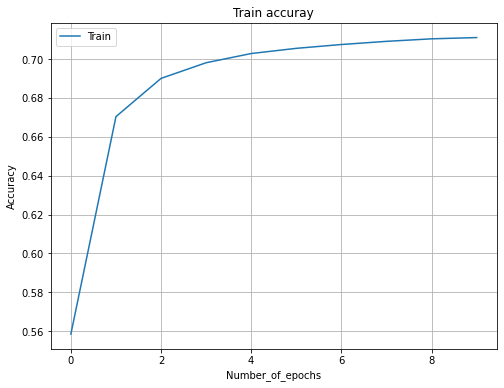

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_acc)
plt.xlabel('Number_of_epochs')
plt.ylabel('Accuracy')
plt.title('Train accuray')
plt.legend(['Train'])
plt.grid('True')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 55, 55, 10, 128)   204928    
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 227, 227, 10, 1)   1

## Load model

In [ ]:
model=load_model("saved_model.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Reading a test video file 

In [ ]:
cap = cv2.VideoCapture("C:\\Users\\Developer\\Desktop\\Testing cam1\\cam12\\individual files\\ch03_20210719133111_normal.mp4")
print(cap.isOpened())

True


## Testing for Abnormal activity in a test video file

In [ ]:
flag=0
while cap.isOpened():
    imagedump=[]
    ret,frame=cap.read()

    for i in range(10):
        ret,frame=cap.read()
        
        if not hasattr(frame,'shape'):
            flag=1
            break
        
        image = imutils.resize(frame,width=640,height=360)

        frame=cv2.resize(frame, (640,360), interpolation = cv2.INTER_AREA)
        gray=0.2989*frame[:,:,0]+0.5870*frame[:,:,1]+0.1140*frame[:,:,2]
        gray=(gray-gray.mean())/gray.std()
        gray=np.clip(gray,0,1)
        imagedump.append(gray)
    
    if flag==1:
        break

    imagedump=np.array(imagedump)
    #print(imagedump)

    imagedump.resize(227,227,10)
    imagedump=np.expand_dims(imagedump,axis=0)
    imagedump=np.expand_dims(imagedump,axis=4)
    
    #print(imagedump)

    output=model.predict(imagedump)

    loss=mean_squared_loss(imagedump,output)
    
    print(loss)

    if frame.any()==None:
        print("none")

    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
    if (loss>0.00066 and loss<0.000675) or (loss>0.00069 and loss<0.00071):                
        print('Abnormal Event Detected')
        cv2.putText(image,"Abnormal Event",(100,100),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),4,cv2.LINE_AA)

    cv2.imshow("video",image)

cap.release()
cv2.destroyAllWindows()

0.0006873388674438122
0.0006850778236904545
0.0006832955674387294
0.0006825481977133269
0.000681964739440286
0.0006813001804923627
0.0006808422789048665
0.0006807589807970203
0.0006808015044200784
0.0006809205364325589
0.0006798685163908004
0.0006810240595772615
0.0006817710686419128
0.0006830738244114242
0.0006827911658895275
0.0006833613671516413
0.0006835183582997029
0.0006837453529216484
0.0006836973110223285
0.0006840260050660809
0.0006841596015733871
0.000684113355618616
0.0006845460981327504
0.0006847436054186332
0.0006846812246247346
0.0006845697442177642
0.0006841491846918875
0.0006837660378708219
0.0006835406019687371
0.0006835635167627178
0.0006837931139642006
0.0006842298004747477
0.0006898841877826472
0.0006897003940438903
0.0006900683200690102
Abnormal Event Detected
0.0006900699037743243
Abnormal Event Detected
0.0006901998599481975
Abnormal Event Detected
0.0006906202833737863
Abnormal Event Detected
0.0006909748613346756
Abnormal Event Detected
0.0006910113399569232
Ab